In [1]:
import spacy
import prodigy
import re

In [2]:
import spacy
from spacy.training import Corpus
from spacy.tokens import DocBin

import pandas as pd

In [3]:
from spacy.language import Language
from Weighted_TextCategorizer import TextCategorizer

In [4]:
spacy.require_gpu()


True

In [5]:

# doc_bin = DocBin().from_disk("/home/vs428/project/Moore_data/followup_impression_data/dev.spacy")
# doc_bin = DocBin().from_disk("/home/vs428/project/Moore_data/followup_impression_data_1_11_2023/dev.spacy")

In [6]:
# Language.factories['weighted_textcat'] = lambda nlp, **cfg: Weighted_TextCategorizer(nlp, **cfg) 

In [7]:
# This model was made for impression only text, so we have to run it on that
nlp = spacy.load("/home/vs428/Documents/Moore/followup_model/model-best")

class weights: [ 1. 75. 24.]


In [8]:
analysis = nlp.analyze_pipes(pretty=True)


============================= Pipeline Overview =============================

#   Component     Assigns          Requires   Scores            Retokenizes
-   -----------   --------------   --------   ---------------   -----------
0   transformer   doc._.trf_data                                False      
                                                                           
1   custom        doc.cats                    cats_score        False      
                                              cats_score_desc              
                                              cats_micro_p                 
                                              cats_micro_r                 
                                              cats_micro_f                 
                                              cats_macro_p                 
                                              cats_macro_r                 
                                              cats_macro_f                 
        

In [188]:
# input_file = '/home/vs428/project/Moore_data/all_moore_cts.csv'
# input_file = '/home/vs428/project/Moore_data/Chest_CT_Reports_HVRADS.csv'

input_file = "/home/vs428/project/Moore_data/CT_93966.csv"

In [189]:
# data_in = pd.read_csv(input_file)
data_in = pd.read_csv(input_file, names=["patient_ID", "MRN", "ENC_CSN_ID", "RD_ID", "KL_ID", "text"])

In [190]:
data_in.columns

Index(['patient_ID', 'MRN', 'ENC_CSN_ID', 'RD_ID', 'KL_ID', 'text'], dtype='object')

In [191]:
# data_in = data_in.drop([ 'Unnamed: 1', 'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4',
#        'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9',
#        'Unnamed: 10', 'Unnamed: 11'], axis=1).reset_index()

In [192]:
data_in = data_in.reset_index()

In [193]:
data_in

,index,patient_ID,MRN,ENC_CSN_ID,RD_ID,KL_ID,text
0,0,39171732,MR1515627,183181823,RD_13507,KL_12943,NaN
1,1,39171732,MR1515627,183288981,RD_13507,KL_12943,CTA CHEST (PE) W IV CONTRAST INDICATION: CP o...
2,2,39171732,MR1515627,183181823,RD_13507,KL_20625,NaN
3,3,39171732,MR1515627,183288981,RD_13507,KL_20625,CTA CHEST (PE) W IV CONTRAST INDICATION: CP o...
4,4,29530916,MR6010698,182917563,RD_10347,KL_14997,NaN
...,...,...,...,...,...,...,...
93961,93961,13483478,MR2519855,266564050,RD_5644,KL_9751,Yale Radiology and Biomedical Imaging** ORIGIN...
93962,93962,44392700,MR5721053,268196656,RD_16598,KL_18849,Yale Radiology and Biomedical Imaging** ORIGIN...
93963,93963,13134339,MR2538725,265763539,RD_4586,KL_24924,Yale Radiology and Biomedical Imaging** ORIGIN...
93964,93964,10719287,MR2279041,218245067,RD_1332,KL_532,"\ CT CHEST ABDOMEN PELVIS W IV CONTRAST, CT 2D..."


In [194]:
data_in = data_in.rename({"text":"CT_Text"}, axis = 1)

In [195]:
# data_in['CT_Text'].fillna("")

In [196]:
data_in.shape[0]

93966

<AxesSubplot: >

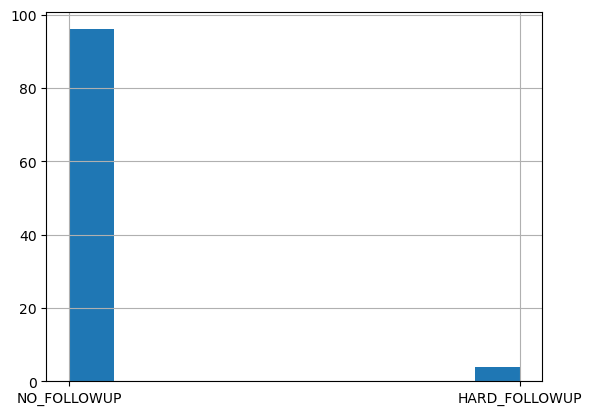

In [197]:
# Test out the prediction
docs = list(nlp.pipe(data_in.sample(100)['CT_Text'].tolist()))
cats = [max(x.cats, key=x.cats.get) for x in docs] 
cats = pd.Series(cats)#.hist()
cats.hist()

In [198]:
# Convert text into IMPRESSIONS only
import math


impressions = []
for idx, text in data_in.loc[~data_in['CT_Text'].isnull(), 'CT_Text'].items():
    try:
        impression = text
        if re.search(r"IMPRESSION:|Impression:", text):
            idx_start = re.search(r"IMPRESSION:|Impression:", text).start()
        else:
            idx_start = 0
        impression = text[idx_start:]
        impressions.append(impression)
    except ValueError:
        impressions.append(ann)
        

In [199]:
data_in.loc[~data_in['CT_Text'].isnull(), 'CT_Text_Impressions'] = impressions

In [200]:
data_in[~data_in['CT_Text'].isnull()]['CT_Text_Impressions'].str.startswith('').sum()

93899

In [201]:
# Run it on the full set
# taken from https://stackoverflow.com/a/44764557/1726404
'''
This works by using nlp.pipe and putting our records into tuples. We process it as tuples and get the context
In our work, the context is just the study id. 
We get the entity text, label, start and stop characters for each entity
we convert that to a json string, we then put the [context,json] together into a list
append this list to nlp_out
then turn nlp out into a df with 1 col being study id and the other being the nlp out
Finally we merge the df with our main data df. Now we have a column with the text
'''
import json
nlp_out = []
count = 0
# for doc, ctx in nlp.pipe(list(data_in[['CT_Text_Impressions', 'KL_ID']].to_records(index=False)),
for doc, ctx in nlp.pipe(list(data_in.loc[~data_in['CT_Text_Impressions'].isnull(), ['CT_Text_Impressions', 'index']].to_records(index=False)),
                                    as_tuples=True, batch_size=200, n_process=1):
    out_ = doc.cats
    nlp_out.append([ctx, json.dumps(out_, indent = 2)])
    count +=1
    if count % 500 == 0:
        print(count)        
        # break
# nlp_df = pd.DataFrame(nlp_out, columns=['KL_ID', 'NLP_OUT'])
nlp_df = pd.DataFrame(nlp_out, columns=['index', 'NLP_OUT'])

500
1000
1500
2000
2500
3000
3500
4000
4500
5000
5500
6000
6500
7000
7500
8000
8500
9000
9500
10000
10500
11000
11500
12000
12500
13000
13500
14000
14500
15000
15500
16000
16500
17000
17500
18000
18500
19000
19500
20000
20500
21000
21500
22000
22500
23000
23500
24000
24500
25000
25500
26000
26500
27000
27500
28000
28500
29000
29500
30000
30500
31000
31500
32000
32500
33000
33500
34000
34500
35000
35500
36000
36500
37000
37500
38000
38500
39000
39500
40000
40500
41000
41500
42000
42500
43000
43500
44000
44500
45000
45500
46000
46500
47000
47500
48000
48500
49000
49500
50000
50500
51000
51500
52000
52500
53000
53500
54000
54500
55000
55500
56000
56500
57000
57500
58000
58500
59000
59500
60000
60500
61000
61500
62000
62500
63000
63500
64000
64500
65000
65500
66000
66500
67000
67500
68000
68500
69000
69500
70000
70500
71000
71500
72000
72500
73000
73500
74000
74500
75000
75500
76000
76500
77000
77500
78000
78500
79000
79500
80000
80500
81000
81500
82000
82500
83000
83500
84000
84500
85000


In [212]:
nlp_df

,index,NLP_OUT
0,1,"{\n ""NO_FOLLOWUP"": 0.9993934631347656,\n ""HA..."
1,3,"{\n ""NO_FOLLOWUP"": 0.9993934631347656,\n ""HA..."
2,6,"{\n ""NO_FOLLOWUP"": 0.9994078874588013,\n ""HA..."
3,8,"{\n ""NO_FOLLOWUP"": 0.9994078874588013,\n ""HA..."
4,10,"{\n ""NO_FOLLOWUP"": 0.004622287582606077,\n ""..."
...,...,...
93894,93961,"{\n ""NO_FOLLOWUP"": 0.9994033575057983,\n ""HA..."
93895,93962,"{\n ""NO_FOLLOWUP"": 0.9994058609008789,\n ""HA..."
93896,93963,"{\n ""NO_FOLLOWUP"": 0.999393105506897,\n ""HAR..."
93897,93964,"{\n ""NO_FOLLOWUP"": 0.9993982315063477,\n ""HA..."


In [213]:
df = nlp_df

In [214]:
import ast

In [215]:
df['NLP_OUT']

0        {\n  "NO_FOLLOWUP": 0.9993934631347656,\n  "HA...
1        {\n  "NO_FOLLOWUP": 0.9993934631347656,\n  "HA...
2        {\n  "NO_FOLLOWUP": 0.9994078874588013,\n  "HA...
3        {\n  "NO_FOLLOWUP": 0.9994078874588013,\n  "HA...
4        {\n  "NO_FOLLOWUP": 0.004622287582606077,\n  "...
                               ...                        
93894    {\n  "NO_FOLLOWUP": 0.9994033575057983,\n  "HA...
93895    {\n  "NO_FOLLOWUP": 0.9994058609008789,\n  "HA...
93896    {\n  "NO_FOLLOWUP": 0.999393105506897,\n  "HAR...
93897    {\n  "NO_FOLLOWUP": 0.9993982315063477,\n  "HA...
93898    {\n  "NO_FOLLOWUP": 0.011134239844977856,\n  "...
Name: NLP_OUT, Length: 93899, dtype: object

In [216]:
def convert_dict_str_to_dict(x, col_name):
    tmp = ast.literal_eval(x[col_name])
    return tmp

In [ ]:
score_df = df.apply(convert_dict_str_to_dict, axis=1, col_name="NLP_OUT", result_type="expand")

In [ ]:
df = pd.concat([df, score_df], axis=1)

In [ ]:
df['y_pred'] = df[["NO_FOLLOWUP","HARD_FOLLOWUP", "CONDITIONAL_FOLLOWUP"]].idxmax(axis=1)

In [ ]:
df

,index,NLP_OUT,NO_FOLLOWUP,HARD_FOLLOWUP,CONDITIONAL_FOLLOWUP,y_pred
0,1,"{\n ""NO_FOLLOWUP"": 0.9993934631347656,\n ""HA...",0.999393,0.000101,0.000505,NO_FOLLOWUP
1,3,"{\n ""NO_FOLLOWUP"": 0.9993934631347656,\n ""HA...",0.999393,0.000101,0.000505,NO_FOLLOWUP
2,6,"{\n ""NO_FOLLOWUP"": 0.9994078874588013,\n ""HA...",0.999408,0.000099,0.000493,NO_FOLLOWUP
3,8,"{\n ""NO_FOLLOWUP"": 0.9994078874588013,\n ""HA...",0.999408,0.000099,0.000493,NO_FOLLOWUP
4,10,"{\n ""NO_FOLLOWUP"": 0.004622287582606077,\n ""...",0.004622,0.987042,0.008336,HARD_FOLLOWUP
...,...,...,...,...,...,...
93894,93961,"{\n ""NO_FOLLOWUP"": 0.9994033575057983,\n ""HA...",0.999403,0.000098,0.000498,NO_FOLLOWUP
93895,93962,"{\n ""NO_FOLLOWUP"": 0.9994058609008789,\n ""HA...",0.999406,0.000098,0.000496,NO_FOLLOWUP
93896,93963,"{\n ""NO_FOLLOWUP"": 0.999393105506897,\n ""HAR...",0.999393,0.000100,0.000507,NO_FOLLOWUP
93897,93964,"{\n ""NO_FOLLOWUP"": 0.9993982315063477,\n ""HA...",0.999398,0.000099,0.000502,NO_FOLLOWUP


In [225]:
# data_in = data_in.merge(df, on="KL_ID")
# data_in = data_in.merge(df, on="index")
x = data_in.merge(df, on="index", how='left')

In [226]:
x['y_pred'].value_counts(normalize=True)

NO_FOLLOWUP             0.947124
HARD_FOLLOWUP           0.036113
CONDITIONAL_FOLLOWUP    0.016763
Name: y_pred, dtype: float64

In [227]:
x

,index,patient_ID,MRN,ENC_CSN_ID,RD_ID,KL_ID,CT_Text,CT_Text_Impressions,NLP_OUT,NO_FOLLOWUP,HARD_FOLLOWUP,CONDITIONAL_FOLLOWUP,y_pred
0,0,39171732,MR1515627,183181823,RD_13507,KL_12943,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1,39171732,MR1515627,183288981,RD_13507,KL_12943,CTA CHEST (PE) W IV CONTRAST INDICATION: CP o...,CTA CHEST (PE) W IV CONTRAST INDICATION: CP o...,"{\n ""NO_FOLLOWUP"": 0.9993934631347656,\n ""HA...",0.999393,0.000101,0.000505,NO_FOLLOWUP
2,2,39171732,MR1515627,183181823,RD_13507,KL_20625,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,39171732,MR1515627,183288981,RD_13507,KL_20625,CTA CHEST (PE) W IV CONTRAST INDICATION: CP o...,CTA CHEST (PE) W IV CONTRAST INDICATION: CP o...,"{\n ""NO_FOLLOWUP"": 0.9993934631347656,\n ""HA...",0.999393,0.000101,0.000505,NO_FOLLOWUP
4,4,29530916,MR6010698,182917563,RD_10347,KL_14997,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
93961,93961,13483478,MR2519855,266564050,RD_5644,KL_9751,Yale Radiology and Biomedical Imaging** ORIGIN...,Yale Radiology and Biomedical Imaging** ORIGIN...,"{\n ""NO_FOLLOWUP"": 0.9994033575057983,\n ""HA...",0.999403,0.000098,0.000498,NO_FOLLOWUP
93962,93962,44392700,MR5721053,268196656,RD_16598,KL_18849,Yale Radiology and Biomedical Imaging** ORIGIN...,Yale Radiology and Biomedical Imaging** ORIGIN...,"{\n ""NO_FOLLOWUP"": 0.9994058609008789,\n ""HA...",0.999406,0.000098,0.000496,NO_FOLLOWUP
93963,93963,13134339,MR2538725,265763539,RD_4586,KL_24924,Yale Radiology and Biomedical Imaging** ORIGIN...,Yale Radiology and Biomedical Imaging** ORIGIN...,"{\n ""NO_FOLLOWUP"": 0.999393105506897,\n ""HAR...",0.999393,0.000100,0.000507,NO_FOLLOWUP
93964,93964,10719287,MR2279041,218245067,RD_1332,KL_532,"\ CT CHEST ABDOMEN PELVIS W IV CONTRAST, CT 2D...","\ CT CHEST ABDOMEN PELVIS W IV CONTRAST, CT 2D...","{\n ""NO_FOLLOWUP"": 0.9993982315063477,\n ""HA...",0.999398,0.000099,0.000502,NO_FOLLOWUP


In [228]:
# data_in.to_csv("/home/vs428/project/Moore_data/all_moore_cts_impressions_1-11-2023_followup_pred.csv", index=False)
x.to_csv("/home/vs428/project/Moore_data/CT_93966_predictions.csv", index=False)

In [5]:
!python run_followup_pipeline.py 

class weights: [ 1. 75. 24.]
created impressions...
50
100
150
200
250
300
350
400
450
500
550
600
650
700
750
800
850
ran predictions...
NO_FOLLOWUP             0.786682
HARD_FOLLOWUP           0.127540
CONDITIONAL_FOLLOWUP    0.085779
Name: y_pred, dtype: float64
